## FIT 5202 Data Processing in Big Data

### Assignment 2A:  Building Models to Predict the Prospective Customers

Name: Napoj Thanomkul

Student ID: 32338589

Tutorial number and Tutor name: Laboratory 03 and Choiru Za'in and Hongli Song

### Introduction

This assignment will be covered on a process of devoloping a machine learning model to identify the potential customers that may have any Top Up services in the future. The process will be described as the following below:

1. Data Preparation and Exploration
2. Feature extraction and ML training
3. Knowledge sharing

Also, this assignment model will be used for the data-streaming process in the next part of the assignment. The following below is how the assignment is done: 

#### Part 1  Data Preparation and Exploration

In this section, two dataframes (customer and bureau) will be imported. Once they are imported as dataframe, they will be in a data pre-processing and explore before putting into the machine learning pipeline as the following:

##### 1.1 Creating Spark Session

Firstly, we need to create a spark session in order to operating all the process.

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment 2: Building Models to Predict the Prospective Customers "
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkSession classes 
from pyspark.sql import SparkSession # Spark SQL

#TODO : Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

sc

<SparkContext master=local[*] appName=Assignment 2: Building Models to Predict the Prospective Customers >

##### 1.2 Loading the Data

After the spark session is created, we will import the two files into our work directory by using `os` library to our current directory and import the files. Then, we will take a look at the schema of each variables. 

In [2]:
#Getting the current path where the files is collected
import os 
home_path=os.getcwd()

#import the csv file as dataframe
customer_df=spark.read.format('csv').options(header='True',inferSchema='True').load(home_path+'/data/customer.csv')
bureau_df = spark.read.format('csv').options(header='True',inferSchema='True').load(home_path+'/data/bureau.csv')

In [3]:
#Print Schema
customer_df.printSchema()
bureau_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte: string (nullable = true)
 |-- AuthDate: string (nullable = true)
 |-- AssetID: integer (nullable = true)
 |-- ManufacturerID: integer (nullable = true)
 |-- SupplierID: integer (nullable = true)
 |-- LTV: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZiPCODE: integer

##### 1.2.1 Change the variable with ID to a string

When explore our two files schemas, it seems that the variables in bureau dataframe with the `ID` in their name got a wrong data type. This issue can be fixed by using `withColumn` and `.cast` to change the data type of those variables to a string as the following:

In [4]:
#Change the column type of the customer dataframe
customer_df = customer_df.withColumn('BranchID',customer_df.BranchID.cast('string'))\
              .withColumn('AssetID',customer_df.AssetID.cast('string'))\
              .withColumn('ManufacturerID',customer_df.ManufacturerID.cast('string'))\
              .withColumn('SupplierID',customer_df.SupplierID.cast('string'))


customer_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte: string (nullable = true)
 |-- AuthDate: string (nullable = true)
 |-- AssetID: string (nullable = true)
 |-- ManufacturerID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- LTV: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZiPCODE: integer (nu

Once the preparation is finished, we need to identify what variables we need to be working on. This process can be done by making a list of different datatypes columns so it is efficient to identify those column before moving on to the next section as the following:

In [5]:
#Make a list of different type of column (non_string and string column)
non_bureau_string = ['WRITE-OFF-AMT','SELF-INDICATOR','ID','TENURE']
bureau_string = [colu for colu in bureau_df.columns if colu not in non_bureau_string]

print(bureau_string)

['MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT', 'CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT', 'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL', 'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'ASSET_CLASS', 'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST', 'AMT OVERDUE - HIST', 'AMT PAID - HIST']


##### 1.2.2 Pre-processing with the string data type column

As we have differentiate the datetype columns, now we will be working manipulate the string columns. We can do this process by changing the string columns with numeric value with a comma to an integer and delete the postfix. In the following case, the udf function of replacing ',' will be created by using `f`,`col`,and `udf` along with a loop for the string columns we created above. Also, we will use `regexp_replace` to create a regular expression to remove a postfix on `INSTALLMEN_AMT` column which consist of numeric value as the following:

In [6]:
import pyspark.sql.functions as f
from pyspark.sql.functions import udf,col


#Replace the column with comma to number and change it into numeric column 
for cols in bureau_string:
    #Remove comma
    bureau_df = bureau_df.withColumn(cols,f.udf(lambda x: x.replace(',','') if x is not None
                                               else None)(f.col(cols)))
                                        
#Change the value of 'INSTALLMENT-AMT' column (NNK,2022c)
bureau_df=bureau_df.withColumn('INSTALLMENT-AMT',f.regexp_replace(f.col('INSTALLMENT-AMT'),"[\$#,A-Za-z/]", ""))

In [7]:
#Show the result
bureau_df.show(5)

+---+--------------+----------+--------------------+----------------+-------------------+-------------+--------------+-------------------+-------------------+-------------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+---------------+------+
| ID|SELF-INDICATOR|MATCH-TYPE|           ACCT-TYPE|CONTRIBUTOR-TYPE|      DATE-REPORTED|OWNERSHIP-IND|ACCOUNT-STATUS|       DISBURSED-DT|           CLOSE-DT|  LAST-PAYMENT-DATE|CREDIT-LIMIT/SANC AMT|DISBURSED-AMT/HIGH CREDIT|INSTALLMENT-AMT|CURRENT-BAL|INSTALLMENT-FREQUENCY|OVERDUE-AMT|WRITE-OFF-AMT|ASSET_CLASS|REPORTED DATE - HIST|          DPD - HIST|      CUR BAL - HIST|  AMT OVERDUE - HIST|AMT PAID - HIST|TENURE|
+---+--------------+----------+--------------------+----------------+-------------------+-------------+--------------+-------------------+------------------

Now that the comma and postfix is removed from the column, what we have to do is identify which column we need to change into an integer. This process can be done by using `regexp_extract` to find the column that have a numeric value only on each columns as the following:

In [8]:
#Identify which column that need to be changed to integer data type (marc,2020)
from pyspark.sql.functions import regexp_extract

ident_df = bureau_df.select(bureau_string)

for cols in ident_df.columns:
    ident_df = ident_df.withColumn(cols,regexp_extract(cols,'\d+',0)) 

#Show the result
ident_df.show(1)

+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-----------+--------------------+--------------------+--------------------+------------------+---------------+
|MATCH-TYPE|ACCT-TYPE|CONTRIBUTOR-TYPE|DATE-REPORTED|OWNERSHIP-IND|ACCOUNT-STATUS|DISBURSED-DT|CLOSE-DT|LAST-PAYMENT-DATE|CREDIT-LIMIT/SANC AMT|DISBURSED-AMT/HIGH CREDIT|INSTALLMENT-AMT|CURRENT-BAL|INSTALLMENT-FREQUENCY|OVERDUE-AMT|ASSET_CLASS|REPORTED DATE - HIST|          DPD - HIST|      CUR BAL - HIST|AMT OVERDUE - HIST|AMT PAID - HIST|
+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-----------+--------------------+--------------------+--------------------+-------

According to the result shown above, it seems that the column that need to be changed include every string column that got numeric value except `Date` , `Hist`, `MATCH-TYPE`, `ACCT-TYPE`, `CONTRIBUTOR-TYPE`, `OWNERSHIP-IND`, `ACCOUNT-STATUS`, `INSTALLMENT-FREQUENCY` and `ASSET_CLASS`.

In [9]:
#Change the column which column with numeric value to integer except the date and hist column
num_col = [x for x in bureau_string if 'HIST' not in x if 'DATE' not in x 
           if 'DT' not in x if x != 'MATCH-TYPE' if x != 'ACCT-TYPE' if x !=
          'CONTRIBUTOR-TYPE' if x != 'OWNERSHIP-IND' if x != 'ACCOUNT-STATUS' if  x != 
          'INSTALLMENT-FREQUENCY' if x != 'ASSET_CLASS']

for num in num_col:
    bureau_df=bureau_df.withColumn(num,bureau_df[num].cast('Integer'))

#Here is the column that need to be change
print(f'Column that need to be changed to numeric:\n{num_col}\n')
bureau_df.printSchema()

Column that need to be changed to numeric:
['CREDIT-LIMIT/SANC AMT', 'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL', 'OVERDUE-AMT']

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: string (nullable = true)
 |-- CLOSE-DT: string (nullable = true)
 |-- LAST-PAYMENT-DATE: string (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: integer (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- INSTALLMENT-AMT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- ASSET_CLASS: 

##### 1.2.3 Identify null in each rows of customer dataframe

Once some of the columns in bureau dataframe is changed, now we will be moving on to the customer dataframe to identify whether there is a null in each rows of the dataframe. This process can be done by using `.na.drop()` on customer dataframe to drop the null first and count all the rows of customer dataframe before we remove null. Then, we will subtract the count of customer before removing null with the null-removed customer dataframe to identify how many rows which got null values as the following:

In [10]:
#Remove row of customer which got null (Jiris,2016)
customer_drop=customer_df.na.drop()
customer_count = customer_df.count()


#Count the number of null by row in customer dataframe
count_null_row = customer_count - customer_drop.count()
print(f'There are null in {count_null_row} for customer dataframe.')

#remove the null 
customer_df = customer_drop

There are null in 22092 for customer dataframe.


The result show that we got 22092 nulls in customer dataframe. Then we will remove those rows which got nulls before moving on to the next part.

In [11]:
#Check whether there is null after it was drop (method derieve from tutorial week 5)
from pyspark.sql.functions import isnan, when, count, col
customer_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in customer_df.columns]).show()

+---+---------+-------------+----------+-----------+--------+----+------+---------+-------------+---------------+---+-------------+------------+--------+-------+--------------+----------+---+---+---+-------------+----+-----+-------+------------+
| ID|Frequency|InstlmentMode|LoanStatus|PaymentMode|BranchID|Area|Tenure|AssetCost|AmountFinance|DisbursalAmount|EMI|DisbursalDate|MaturityDAte|AuthDate|AssetID|ManufacturerID|SupplierID|LTV|SEX|AGE|MonthlyIncome|City|State|ZiPCODE|Top-up Month|
+---+---------+-------------+----------+-----------+--------+----+------+---------+-------------+---------------+---+-------------+------------+--------+-------+--------------+----------+---+---+---+-------------+----+-----+-------+------------+
|  0|        0|            0|         0|          0|       0|   0|     0|        0|            0|              0|  0|            0|           0|       0|      0|             0|         0|  0|  0|  0|            0|   0|    0|      0|           0|
+---+---------+-

##### 1.2.4 Identify null percentages in each columns of bureau dataframe

After we have identify the null in the customer dataframe, we will identify the percentage of null in bureau dataframe column with the same function as the previous section. Before that, we need to change the self-indicator from boolean datatype to string.


In [12]:
#Change the self_indicator to string before counting the null of all column (The code derieve from tutorial week 5)
bureau_df2 = bureau_df.withColumn('SELF-INDICATOR',bureau_df['SELF-INDICATOR'].cast('String'))
bureau_df_count = bureau_df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in bureau_df2.columns])

bureau_df_count.show()

+---+--------------+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-------------+-----------+--------------------+----------+--------------+------------------+---------------+------+
| ID|SELF-INDICATOR|MATCH-TYPE|ACCT-TYPE|CONTRIBUTOR-TYPE|DATE-REPORTED|OWNERSHIP-IND|ACCOUNT-STATUS|DISBURSED-DT|CLOSE-DT|LAST-PAYMENT-DATE|CREDIT-LIMIT/SANC AMT|DISBURSED-AMT/HIGH CREDIT|INSTALLMENT-AMT|CURRENT-BAL|INSTALLMENT-FREQUENCY|OVERDUE-AMT|WRITE-OFF-AMT|ASSET_CLASS|REPORTED DATE - HIST|DPD - HIST|CUR BAL - HIST|AMT OVERDUE - HIST|AMT PAID - HIST|TENURE|
+---+--------------+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-------------+-

According to the above result, it seems that there are many nulls in several column. Next process we need to proceed is identify the percentage of the null by using the udf function to calculate the percentage and round them to two decimal points as the following:

In [13]:
#Find the percentage of null by each column
total_row = bureau_df2.count()

#Rounding function for identify the percentage
def column_round(x):
    return round(x,2)

round_udf= udf(column_round)

#Apply the loop through all the column to identify the percentage of row by divide the number of null with total rows
for cols in bureau_df2.columns: 
    bureau_df_count = bureau_df_count.withColumn(cols,round_udf(bureau_df_count[cols]/total_row))
    bureau_df_count = bureau_df_count.withColumn(cols,bureau_df_count[cols].cast('float'))
    
bureau_df_count.show()

+---+--------------+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-------------+-----------+--------------------+----------+--------------+------------------+---------------+------+
| ID|SELF-INDICATOR|MATCH-TYPE|ACCT-TYPE|CONTRIBUTOR-TYPE|DATE-REPORTED|OWNERSHIP-IND|ACCOUNT-STATUS|DISBURSED-DT|CLOSE-DT|LAST-PAYMENT-DATE|CREDIT-LIMIT/SANC AMT|DISBURSED-AMT/HIGH CREDIT|INSTALLMENT-AMT|CURRENT-BAL|INSTALLMENT-FREQUENCY|OVERDUE-AMT|WRITE-OFF-AMT|ASSET_CLASS|REPORTED DATE - HIST|DPD - HIST|CUR BAL - HIST|AMT OVERDUE - HIST|AMT PAID - HIST|TENURE|
+---+--------------+----------+---------+----------------+-------------+-------------+--------------+------------+--------+-----------------+---------------------+-------------------------+---------------+-----------+---------------------+-----------+-------------+-

As the result shown above, it seems that there are several columns that got more than 20% of nulls, so we have to remove them by make them into a list then remove them by `.drop` on dataframe as below:

In [14]:
#Show the column which have percentage of null over 20%
column_drop = [cols for cols in bureau_df_count.columns if bureau_df_count.collect()[0][cols] > 0.2]
print(column_drop)

['CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT', 'INSTALLMENT-AMT', 'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'ASSET_CLASS', 'TENURE']


In [15]:
#Drop the column which have null percentage over 20%
bureau_df = bureau_df.drop(*column_drop)
bureau_df.show(5)

+---+--------------+----------+--------------------+----------------+-------------------+-------------+--------------+-------------------+-------------------------+-----------+-------------+--------------------+--------------------+--------------------+--------------------+---------------+
| ID|SELF-INDICATOR|MATCH-TYPE|           ACCT-TYPE|CONTRIBUTOR-TYPE|      DATE-REPORTED|OWNERSHIP-IND|ACCOUNT-STATUS|       DISBURSED-DT|DISBURSED-AMT/HIGH CREDIT|CURRENT-BAL|WRITE-OFF-AMT|REPORTED DATE - HIST|          DPD - HIST|      CUR BAL - HIST|  AMT OVERDUE - HIST|AMT PAID - HIST|
+---+--------------+----------+--------------------+----------------+-------------------+-------------+--------------+-------------------+-------------------------+-----------+-------------+--------------------+--------------------+--------------------+--------------------+---------------+
|  1|         false|   PRIMARY|Auto Loan (Personal)|             NAB|2019-12-31 00:00:00|   Individual|        Active|2018-03-1

##### 1.2.5 Remove DATE and HIST Column from bureau dataframe

After we have drop all the nulls and change some of the columns, now we need to drop `DATE` and `HIST` column as a preparation for mergining two dataframes in the next sections.

In [16]:
new_col = [x for x in bureau_df.columns if 'HIST' not in x if 'DATE' not in x if 'DT' not in x]
bureau_df = bureau_df[new_col]
bureau_df.show(5)

+---+--------------+----------+--------------------+----------------+-------------+--------------+-------------------------+-----------+-------------+
| ID|SELF-INDICATOR|MATCH-TYPE|           ACCT-TYPE|CONTRIBUTOR-TYPE|OWNERSHIP-IND|ACCOUNT-STATUS|DISBURSED-AMT/HIGH CREDIT|CURRENT-BAL|WRITE-OFF-AMT|
+---+--------------+----------+--------------------+----------------+-------------+--------------+-------------------------+-----------+-------------+
|  1|         false|   PRIMARY|Auto Loan (Personal)|             NAB|   Individual|        Active|                    44000|      20797|            0|
|  1|         false|   PRIMARY|           Overdraft|             NAB|   Individual|    Delinquent|                    37352|      37873|            0|
|  1|          true|   PRIMARY|Auto Loan (Personal)|             NBF|   Individual|        Closed|                   400000|          0|            0|
|  1|          true|   PRIMARY|Auto Loan (Personal)|             NBF|   Individual|        Clo

Before moving to the next section `.cache()` will be used so that it will reduce the memory using when process in these two dataframes

In [17]:
#Apply cache to speed up the process if these two dataframes used.(The cache() method derieve from tutorial week 8)
customer_df.cache()
bureau_df.cache()

DataFrame[ID: int, SELF-INDICATOR: boolean, MATCH-TYPE: string, ACCT-TYPE: string, CONTRIBUTOR-TYPE: string, OWNERSHIP-IND: string, ACCOUNT-STATUS: string, DISBURSED-AMT/HIGH CREDIT: int, CURRENT-BAL: int, WRITE-OFF-AMT: int]

#### 1.3 Explore the data

##### 1.3.1 Basic Statistic for both columns

For the following section, we will explore the data before we merge two dataframes. The first process is to explore some basic statistic of each columns as the followings:

Before we looking at the statistic value, we need to exclude `ID` and `Top-up Month` as instruction.

In [18]:
#Identify the column type 
#Column of customer dataframe which is not string exclude ID (NNK,2022a)
Not_string_customer = [field.name for field in customer_df.schema.fields if str(field.dataType) != 'StringType'
                       if field.name != 'ID']


#Column of customer dataframe which is string exclude top-up month
string_customer = [field.name for field in customer_df.schema.fields if str(field.dataType) == 'StringType'
                       if field.name != 'Top-up Month']

Once we exclude those two columns, we are going to looking at the count,mean,standard deviation,min and max for numeirc columns starting with customer dataframe below using `.describe` with `.toPandas` to make it readable.

In [19]:
#Basic desciptive statistic for numeric column of customer dataframe
customer_df.describe(Not_string_customer[:]).toPandas()

,summary,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,LTV,AGE,MonthlyIncome,ZiPCODE
0,count,121308,121308,121308,121308,121308,121308,121308,121308,121308
1,mean,42.75597652257065,563289.852482936,356361.5262638078,356002.3838225838,56821.71514731098,59.62412924127061,40.70355623701652,51901.613624659185,421356.78347676987
2,stddev,22.433473986085666,103558.8450100068,105717.74807158242,105537.25852397742,28585.22968535354,15.81841655789387,11.794657218312981,1774582.5522165233,170779.11249764322
3,min,5,200000,50000.0,2894.0,200.0,-1.38,18,0.0,110000
4,max,501,2250000,1308351.0,1308351.0,460000.0,100.0,90,6.174775E8,855456


After getting the statistic for customer non-string column, we will looking at the count and top ten values of string columns. This can be done by apply the loop through list of string columns and apply `.groupby` and `.count` while `.sort(count,ascending = False)` to get the top 10 count value of each column as belows:

In [20]:
#Top ten value for each non-numeric features and their counts in customer dataframe 
for cols in string_customer:
    string_cus_df = customer_df.groupby(cols).count().sort('count',ascending=False)
    string_cus_df.show(10)

+-----------+-----+
|  Frequency|count|
+-----------+-----+
|Half Yearly|78986|
|    Monthly|22535|
|    Quatrly|19482|
| BI-Monthly|  305|
+-----------+-----+

+-------------+------+
|InstlmentMode| count|
+-------------+------+
|       Arrear|116999|
|      Advance|  4309|
+-------------+------+

+----------+-----+
|LoanStatus|count|
+----------+-----+
|    Closed|86260|
|    Active|35048|
+----------+-----+

+------------+-----+
| PaymentMode|count|
+------------+-----+
|         ECS|33078|
|Direct Debit|32545|
|         PDC|25951|
|      Billed|17668|
|       PDC_E| 9398|
|  Auto Debit|  905|
|   SI Reject|  803|
|      Cheque|  489|
|  ECS Reject|  457|
|      Escrow|    7|
+------------+-----+
only showing top 10 rows

+--------+-----+
|BranchID|count|
+--------+-----+
|      24| 4534|
|     199| 4391|
|     166| 2464|
|      50| 2348|
|     202| 2234|
|     263| 2154|
|      41| 1935|
|     246| 1934|
|      85| 1854|
|     133| 1837|
+--------+-----+
only showing top 10 rows

+

We will also apply the same approach to the bureau dataframe as well. The only difference is that we need to change the `SELF-INDICATOR` form boolean to string before we proceed.

In [21]:
#Identify the column type 
#Column of bureau dataframe which is not string exclude ID
bureau_df=bureau_df.withColumn('SELF-INDICATOR',bureau_df['SELF-INDICATOR'].cast('string'))
Not_string_bureau = [field.name for field in bureau_df.schema.fields if str(field.dataType) != 'StringType'
                       if field.name != 'ID']


#Column of bureau dataframe 
string_bureau = [field.name for field in bureau_df.schema.fields if str(field.dataType) == 'StringType']

In [22]:
bureau_df.describe(Not_string_bureau).toPandas()

,summary,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,WRITE-OFF-AMT
0,count,624825,624598,603179
1,mean,316589.3861433201,103717.07101207497,291.3442643062839
2,stddev,5176936.4467015965,851087.5975786775,19561.75231589789
3,min,-83878,-20868956,-30
4,max,999999999,375991329,8797356


In [23]:
#Top ten value for each non-numeric features and their counts in bureau dataframe
for cols in string_bureau:
    string_bur_df = bureau_df.groupby(cols).count().sort('count',ascending=False)
    string_bur_df.show(10)

+--------------+------+
|SELF-INDICATOR| count|
+--------------+------+
|         false|442851|
|          true|182012|
+--------------+------+

+----------+------+
|MATCH-TYPE| count|
+----------+------+
|   PRIMARY|624638|
| SECONDARY|   225|
+----------+------+

+--------------------+------+
|           ACCT-TYPE| count|
+--------------------+------+
|        Tractor Loan|208051|
|           Gold Loan| 98602|
|Business Loan Pri...| 88274|
|   Kisan Credit Card| 37621|
|Auto Loan (Personal)| 33504|
|               Other| 31729|
|Commercial Vehicl...| 21296|
|    Two-Wheeler Loan| 17656|
|         Credit Card| 14397|
|       Consumer Loan| 13769|
+--------------------+------+
only showing top 10 rows

+----------------+------+
|CONTRIBUTOR-TYPE| count|
+----------------+------+
|             NBF|286311|
|             NAB|191368|
|             PRB| 84392|
|             COP| 26853|
|             RRB| 26374|
|             MFI|  3676|
|             HFC|  3174|
|             CCC|  1651|
| 

##### 1.3.2 Merge bureau dataframe row by ID

As the name in this section, we are going to merge the bureau dataframe rows together based on the `ID` column. In order to do that we will create two separate dataframe based on datatypes of columns. For instance, we have to sum numeric column with the same name with the same ID together like the `HIGH CREDIT` column of every row will be add together if they got the same `ID`. On the other hand the non-numeric column will need to be count the distinct value based on the ID like `ACCOUNT-STATUS` column for one ID might have three different values so it got three for distinct value. Below is how these ideas are implemented:

For numeric column, we apply a `groupby` and `.sum` to columns and change the name to that particular column with`_sum` and store them in a list as shown below:

In [24]:
#Get the sum of numeric columns by ID (Muller, 2018)
sum_df_list = []
for cols in Not_string_bureau:
    num_df = bureau_df.groupby('ID').sum(cols)
    num_df = num_df.withColumnRenamed('sum('+cols+')',cols+'_sum')
    sum_df_list.append(num_df)
sum_df_list[2].show()

+----+-----------------+
|  ID|WRITE-OFF-AMT_sum|
+----+-----------------+
| 148|                0|
| 463|                0|
| 471|                0|
| 496|                0|
| 833|                0|
|1088|           307837|
|1238|                0|
|1342|                0|
|1580|                0|
|1591|                0|
|1645|                0|
|1829|                0|
|1959|                0|
|2122|                0|
|2142|                0|
|2366|                0|
|2659|                0|
|2866|                0|
|3175|                0|
|3749|                0|
+----+-----------------+
only showing top 20 rows



For non-numeric, we count the distinct by the ID by select `ID` and the column, `groupby` it before apply the `count` and change the count column to that particular column name with `_dist` below and store them in a list.

In [25]:
#Get dataframe count the distince value based on the non-numeric column and ID
def create_string_id(column):
    count_dis=bureau_df.select('ID',column).distinct().sort('ID')
    count_dis = count_dis.groupby('ID').count().sort('ID')
    count_dis = count_dis.withColumnRenamed('count',column+'_dist')
    return count_dis


var_dist = [create_string_id(cols) for cols in string_bureau]
        
var_dist[5].show()

+---+-------------------+
| ID|ACCOUNT-STATUS_dist|
+---+-------------------+
|  1|                  3|
|  2|                  2|
|  3|                  3|
|  4|                  2|
|  5|                  2|
|  6|                  2|
|  7|                  2|
|  8|                  4|
|  9|                  1|
| 10|                  2|
| 11|                  2|
| 12|                  1|
| 13|                  1|
| 14|                  2|
| 15|                  2|
| 16|                  1|
| 17|                  1|
| 18|                  2|
| 19|                  1|
| 20|                  3|
+---+-------------------+
only showing top 20 rows



After we got both type of new column we will join the dataframe inside of these two dataframes list together before joining two of these new dataframe together as a new bureau dataframe.

Firstly, we will start with assign new bureau dataframe for new numeric column only and use combination of loop through list of dataframe and using`.join` to join them together to create new dataframe. This process will also be done on the string column as well. This is how the process is done below:

In [26]:
#Merge dataframe for numeric column (thecheech,2017)
num_bureau_df = sum_df_list[0]
for df in sum_df_list[1:]:
    num_bureau_df = num_bureau_df.join(df,on='ID',how='left')

In [27]:
num_bureau_df.show(6)

+----+-----------------------------+---------------+-----------------+
|  ID|DISBURSED-AMT/HIGH CREDIT_sum|CURRENT-BAL_sum|WRITE-OFF-AMT_sum|
+----+-----------------------------+---------------+-----------------+
| 148|                      1305000|          55218|                0|
| 463|                       220000|              0|                0|
| 471|                       300000|              0|                0|
| 496|                      7116120|        4464362|                0|
| 833|                      1004583|         224000|                0|
|1088|                      1978510|          49977|           307837|
+----+-----------------------------+---------------+-----------------+
only showing top 6 rows



In [28]:
#Merge dataframe for non-numeric column
str_bureau_df = var_dist[0]
for df in var_dist[1:]:
    str_bureau_df = str_bureau_df.join(df,on='ID',how='left')

In [29]:
str_bureau_df.show(6)

+------+-------------------+---------------+--------------+---------------------+------------------+-------------------+
|    ID|SELF-INDICATOR_dist|MATCH-TYPE_dist|ACCT-TYPE_dist|CONTRIBUTOR-TYPE_dist|OWNERSHIP-IND_dist|ACCOUNT-STATUS_dist|
+------+-------------------+---------------+--------------+---------------------+------------------+-------------------+
| 11141|                  1|              1|             1|                    1|                 1|                  1|
| 46994|                  2|              1|             3|                    2|                 1|                  2|
| 47711|                  2|              1|             2|                    2|                 1|                  2|
| 56741|                  2|              1|             2|                    2|                 1|                  2|
| 57380|                  2|              1|             2|                    2|                 1|                  3|
|135965|                  2|    

Once we get these two new dataframes, we will join them to get new bureau dataframe.

In [30]:
#Merge two data type of bureau dataframe
new_bureau_df = num_bureau_df.join(str_bureau_df,on='ID',how='left')
new_bureau_df.show(3)

+---+-----------------------------+---------------+-----------------+-------------------+---------------+--------------+---------------------+------------------+-------------------+
| ID|DISBURSED-AMT/HIGH CREDIT_sum|CURRENT-BAL_sum|WRITE-OFF-AMT_sum|SELF-INDICATOR_dist|MATCH-TYPE_dist|ACCT-TYPE_dist|CONTRIBUTOR-TYPE_dist|OWNERSHIP-IND_dist|ACCOUNT-STATUS_dist|
+---+-----------------------------+---------------+-----------------+-------------------+---------------+--------------+---------------------+------------------+-------------------+
|148|                      1305000|          55218|                0|                  2|              1|             3|                    2|                 1|                  2|
|463|                       220000|              0|                0|                  1|              1|             1|                    1|                 1|                  1|
|471|                       300000|              0|                0|                  1| 

##### 1.3.3 Merge two dataframe and make new value for top-up column

In the following step, we will merge the bureau dataframe and customer dataframe together below with an `how = inner` for an inner join on and `ID` column of both dataframes.

In [31]:
#Merge customer dataframe and bureau dataframe by ID
df = new_bureau_df.join(customer_df,on='ID',how='inner')
df.show(5)

+----+-----------------------------+---------------+-----------------+-------------------+---------------+--------------+---------------------+------------------+-------------------+---------+-------------+----------+-----------+--------+--------------------+------+---------+-------------+---------------+-------+-------------------+-------------------+-------------------+--------+--------------+----------+-----+---+---+-------------+-----------+-----------+-------+-----------------+
|  ID|DISBURSED-AMT/HIGH CREDIT_sum|CURRENT-BAL_sum|WRITE-OFF-AMT_sum|SELF-INDICATOR_dist|MATCH-TYPE_dist|ACCT-TYPE_dist|CONTRIBUTOR-TYPE_dist|OWNERSHIP-IND_dist|ACCOUNT-STATUS_dist|Frequency|InstlmentMode|LoanStatus|PaymentMode|BranchID|                Area|Tenure|AssetCost|AmountFinance|DisbursalAmount|    EMI|      DisbursalDate|       MaturityDAte|           AuthDate| AssetID|ManufacturerID|SupplierID|  LTV|SEX|AGE|MonthlyIncome|       City|      State|ZiPCODE|     Top-up Month|
+----+------------------

Next, the `Top-up month` column will be changed to `Top-up` column by using a UDF function make a new label for new `Top-up` column by the 0 represent "No-top up service" otherwise it show as 1 if there is some service requirement. 

In [32]:
#Change the top-up month to top-up and change it value
from pyspark.sql.types import IntegerType

#Label function for top-up value
def label_topup(t):
    label = 0
    if t == 'No Top-up Service':
        label = 0
    else:
        label = 1
    return label

label_udf = udf(label_topup,IntegerType())

#Apply the UDF function and rename the column
final_df = df.withColumn('Top-up Month',label_udf(col('Top-up Month')))
final_df = final_df.withColumnRenamed('Top-up Month','Top-up')

final_df.show(5)

+----+-----------------------------+---------------+-----------------+-------------------+---------------+--------------+---------------------+------------------+-------------------+---------+-------------+----------+-----------+--------+--------------------+------+---------+-------------+---------------+-------+-------------------+-------------------+-------------------+--------+--------------+----------+-----+---+---+-------------+-----------+-----------+-------+------+
|  ID|DISBURSED-AMT/HIGH CREDIT_sum|CURRENT-BAL_sum|WRITE-OFF-AMT_sum|SELF-INDICATOR_dist|MATCH-TYPE_dist|ACCT-TYPE_dist|CONTRIBUTOR-TYPE_dist|OWNERSHIP-IND_dist|ACCOUNT-STATUS_dist|Frequency|InstlmentMode|LoanStatus|PaymentMode|BranchID|                Area|Tenure|AssetCost|AmountFinance|DisbursalAmount|    EMI|      DisbursalDate|       MaturityDAte|           AuthDate| AssetID|ManufacturerID|SupplierID|  LTV|SEX|AGE|MonthlyIncome|       City|      State|ZiPCODE|Top-up|
+----+-----------------------------+----------

##### 1.3.4 Visualisation of the Data

After we have done the exploration on the dataframe, now we will create a two set of visualisation for each dataframe based on our new dataframe. This can be started with turning pyspark dataframe into pandas dataframe by using `.toPandas` then identify column into one for bureau dataframe and one for customer dataframe into different lists. Then make two separate pandas dataframe for visualisation.

In [33]:
#Making pyspark dataframe to pandas for convenient in plotting
pd_final_df = final_df.toPandas()

#Separate column based on customer and bureau data
bureau_cols = [cols for cols in new_bureau_df.columns if cols != 'ID']
customer_cols = [cols for cols in customer_df.columns if cols != 'ID' if cols != 'Top-up Month']
bureau_cols.append('Top-up')
customer_cols.append('Top-up')

#Separate dataframe for plotting
pd_final_df_bureau = pd_final_df[bureau_cols]
pd_final_df_customer = pd_final_df[customer_cols]

In [34]:
pd_final_df_bureau.head()

,DISBURSED-AMT/HIGH CREDIT_sum,CURRENT-BAL_sum,WRITE-OFF-AMT_sum,SELF-INDICATOR_dist,MATCH-TYPE_dist,ACCT-TYPE_dist,CONTRIBUTOR-TYPE_dist,OWNERSHIP-IND_dist,ACCOUNT-STATUS_dist,Top-up
0,1004583,224000,0,2,1,3,3,1,2,0
1,1978510,49977,307837,2,1,5,2,1,4,0
2,400000,0,0,1,1,1,1,1,1,0
3,545996,0,0,2,1,1,1,2,1,0
4,1641295,20509,0,2,1,5,2,3,2,1


Before we start the visualisation, we will install `seaborn` library which support the visualisation along with `matplotlib`

In [35]:
#Install this one before running the correlation plot if you don't have this package
!pip install seaborn 

Once all the preparation is done, we will create the visualisation illustrated below:

##### Correlation plot between all numeric columns from bureau dataframe and Top-up

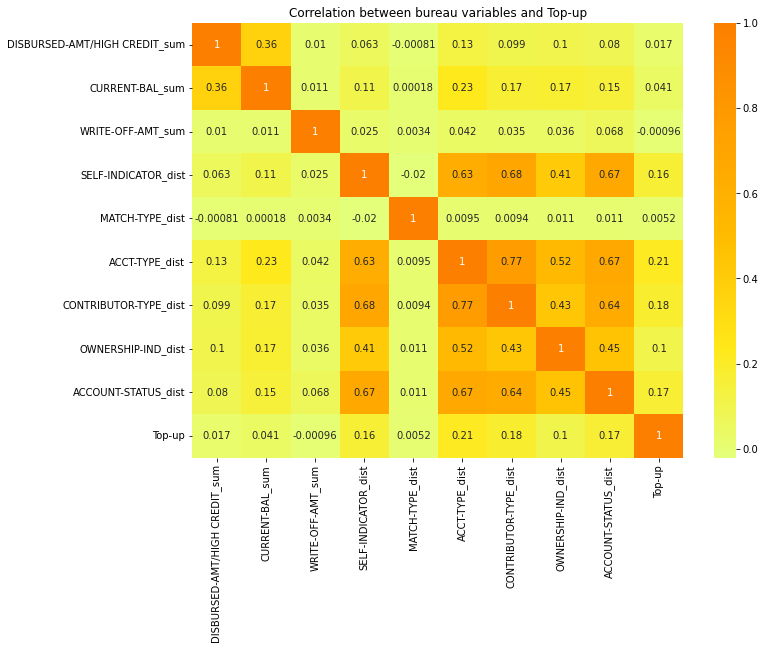

In [36]:
#Correlation plot for bureau_dataframe and top-up (Szabo,2020)
import matplotlib.pyplot as plt
import seaborn as sns

relate = pd_final_df_bureau.corr()
#Correlation plot
plt.figure(figsize=(11,8))
plt.title('Correlation between bureau variables and Top-up')
sns.heatmap(relate, cmap='Wistia',annot=True)
plt.show()

The first plot is the correlation plot between numeric column from bureau dataframe and Top-up. This plot was chosen to be part of the visualisation because it will help us to identify which numeric column is associated with the `Top-up` value. According to the result above, there are four columns that have an association with `Top-up` such as `SELF-INDICATOR_dist`,`ACCT-TYPE`,`CONTRIBUTOR-TYPE_dist`,and `ACCOUNT-STATUS_dist`; while the other numeric columns is not associate at all. In addition, it seems that `ACCT-TYPE` is the most related column with the `Top-up`. Regarding this visualisation and the most correlation value, it lead to another plot as the following:

##### Bar Chart of  ACCT-TYPE

Text(0.5, 1.0, 'Count of People Who Top-up by ACCT-TYPE distinct')

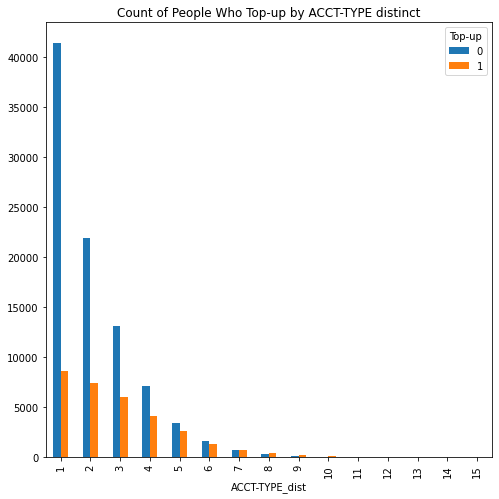

In [37]:
#Plot line graph of the most correlation value between top-up and that variable (tlanigan, 2018) 

pd_final_df_bureau.groupby('ACCT-TYPE_dist')['Top-up'].value_counts().unstack().plot.bar(figsize=(8, 8))
plt.title("Count of People Who Top-up by ACCT-TYPE distinct")

Since `ACCT-TYPE` is the most correlated column to the `Top-value`, the bar plot to see the count between `ACCT-TYPE` and `Top-up` is create in order to identify how distinct account type influence top-up. Based on the visualisation above, it seems that when the distinction is less, the people is tend to do either less top-up or more top-up. 


Now, we will moving on to the visualisation of the customer dataframe which wll be illustated below:

##### Correlation plot between all numeric columns from customer dataframe and Top-up

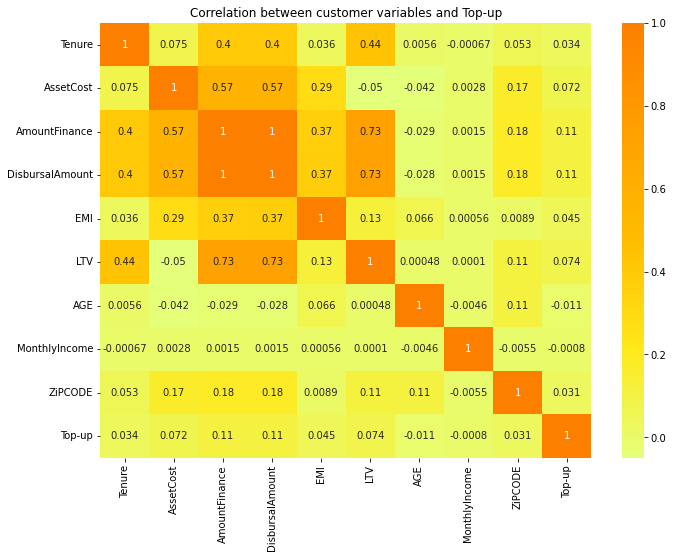

In [38]:
#Correlation plot for customer_data

#Before plotting adding the top-up variable name to Not_string customer list that create in previous section
Not_string_customer.append('Top-up')

relate2 = pd_final_df_customer[Not_string_customer].corr()
#Correlation plot
plt.figure(figsize=(11,8))
plt.title('Correlation between customer variables and Top-up')
sns.heatmap(relate2, cmap='Wistia',annot=True)
plt.show()

This plot for the customer dataframe is similar to the first plot we created. We also want to identify the relationship between customer dataframe numeric column with `Top-up`. For the result of this plot, it seems that there are only two columns that relate with `Top-up`, which is `AmountFinance` and `DisbursalAmount`, with the same correlation value at 0.11.

##### Bar plot of State and Top-up value count

Text(0.5, 1.0, 'Count of loan service by each state')

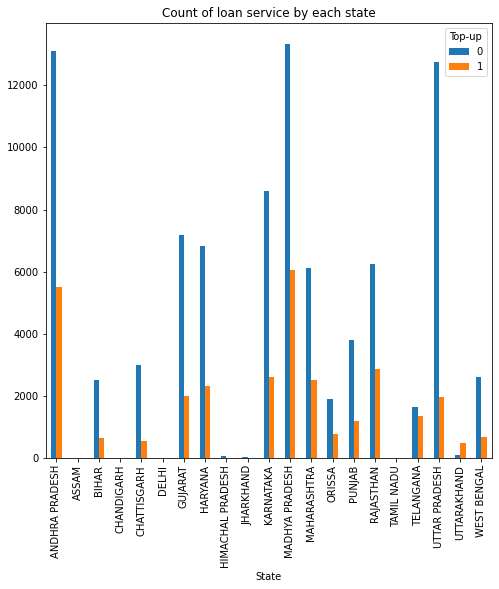

In [39]:
#Bar plot of state value count by the top-up value
count_state =  pd_final_df_customer.groupby('State')['Top-up'].value_counts().unstack().plot.bar(figsize=(8, 8))
plt.title("Count of loan service by each state")

Once we done with all the correlation plot between numeric column and top-up, now we will looking at the plot between non-numeric column and `Top-up`.It would be an ideal if we can plot all the non-numeric column with the `Top-up`; However, we can only plot another one visualisation, so I decided to plot the count of `State` and `Top-up` count because it seems that customer living in a different `State` might have influence the number of `Top-up`. According to the plot result, it seems that living in a different state might influence on the `Top-up` value.

#### Part 2. Feature extraction and ML training

After we have done our data pre-processing and exploration, we will move on to the model developing section which will be proceed in the next following sections below:

##### 2.1 Preparing the training data and testing data

the section will start with splitting our dataframe we got from the previous section into 80% training set and 20% testing set using `.randomSplit` by setting the seed to the number of time that dataset will be shuffling.

In [40]:
train_set,test_set = final_df.randomSplit([0.8, 0.2],seed=100)

After that, we will create an undersampling function to rebalance the training set to be smaller so that it can be train in our model pipeline with short amount of time. The rebalance training set will include 20% of `Top-up` equal '1' value from the whole dataset while the `Top-up` '0' will be double the `1` which show in a ratio of 1:2. The process of making the undersampling will be described in the code as the following:

In [41]:
from pyspark.sql.functions import rand 

#Undersampling the training set based on the number of training set
def undersampling(dataset,ratio):
    """
    This function will be use for making a new reblance training dataset
    which make the 20% top-up with value 1 and double the value 0. This is
    done by filtering the full dataframe for each top-up value
    then resampling using .sample with ratio to the filter datset of value 1
    Then we union it with the select row of filter 0 top-up value dataframe which 
    double the proportion of value 1
    Parameter: 
    Dataset: dataframe that we want to resampling
    ratio: the ratio we want to resampling from th full dataframe
    
    """
    #Filtering the dataframe into 0 and 1 top-up value datframe
    train_0 = dataset.filter(col('Top-up')==0)
    train_1 = dataset.filter(col('Top-up')==1)
    
    #Create 1:2 ratio 
    train1_portion = train_1.sample(ratio,seed=100)
    train0_portion = train1_portion.count()*2
    train0 = spark.createDataFrame(train_0.collect()[:train0_portion]) #New datframe include the double porportion of 0
    train_new_set = train1_portion.union(train0) #Combining two datframe after resampling (NNK,2022b)
    train_new_set = train_new_set.orderBy(rand()) #Shuffling the dataframe with .rand()
    
    return train_new_set

train_new = undersampling(train_set,0.20)
train_new.groupby('Top-up').count().show() #The result

+------+-----+
|Top-up|count|
+------+-----+
|     0|10320|
|     1| 5160|
+------+-----+



As we finished rebalancing our training set, we will show some rows of our new dataframe and using `.cache()` on the new dataframe because we are going to use it many time so it is a good idea to cahche it to spped up the process and reducing memory usage.

In [42]:
#Show the rows of the new rebalance dataframe and apply cache
train_new.show(5)
train_new.cache()

+-----+-----------------------------+---------------+-----------------+-------------------+---------------+--------------+---------------------+------------------+-------------------+-----------+-------------+----------+------------+--------+----------+------+---------+-------------+---------------+--------+-------------------+-------------------+-------------------+--------+--------------+----------+-----+---+---+-------------+-----------+--------------+-------+------+
|   ID|DISBURSED-AMT/HIGH CREDIT_sum|CURRENT-BAL_sum|WRITE-OFF-AMT_sum|SELF-INDICATOR_dist|MATCH-TYPE_dist|ACCT-TYPE_dist|CONTRIBUTOR-TYPE_dist|OWNERSHIP-IND_dist|ACCOUNT-STATUS_dist|  Frequency|InstlmentMode|LoanStatus| PaymentMode|BranchID|      Area|Tenure|AssetCost|AmountFinance|DisbursalAmount|     EMI|      DisbursalDate|       MaturityDAte|           AuthDate| AssetID|ManufacturerID|SupplierID|  LTV|SEX|AGE|MonthlyIncome|       City|         State|ZiPCODE|Top-up|
+-----+-----------------------------+-------------

DataFrame[ID: bigint, DISBURSED-AMT/HIGH CREDIT_sum: bigint, CURRENT-BAL_sum: bigint, WRITE-OFF-AMT_sum: bigint, SELF-INDICATOR_dist: bigint, MATCH-TYPE_dist: bigint, ACCT-TYPE_dist: bigint, CONTRIBUTOR-TYPE_dist: bigint, OWNERSHIP-IND_dist: bigint, ACCOUNT-STATUS_dist: bigint, Frequency: string, InstlmentMode: string, LoanStatus: string, PaymentMode: string, BranchID: string, Area: string, Tenure: bigint, AssetCost: bigint, AmountFinance: double, DisbursalAmount: double, EMI: double, DisbursalDate: string, MaturityDAte: string, AuthDate: string, AssetID: string, ManufacturerID: string, SupplierID: string, LTV: double, SEX: string, AGE: bigint, MonthlyIncome: double, City: string, State: string, ZiPCODE: bigint, Top-up: bigint]

#####  2.2 Preparing Features, Labels, and Models

Once we done with preparing the training dataset, we will preparing our feature and labels before developing our model pipeline. 

##### 2.2.1 Feature selection

It will start with selecting the features based on the data exploration and visualisation from the earlier sections. Based on that section, these are all the features that are selected: 

- 'ACCT-TYPE_dist','CONTRIBUTOR-TYPE_dist','SELF-INDICATOR_dist','ACCOUNT-STATUS_dist','AmountFinance','Frequency','InstlmentMode','LoanStatus','PaymentMode','Area','DisbursalAmount','SEX','City','State'

The reason for these features being select is that some of them is related with the `Top-up` value such as `CONTRIBUTOR-TYPE_dist`,`SELF-INDICATOR_dist`,`ACCOUNT-STATUS_dist`,`AmountFinance` and `DisbursalAmount` based on the correlation result. On the other hand, we also include most of the non-numeric features such as `Frequency`,`InstlmentMode`,`LoanStatus`,`PaymentMode`,`Area`,`SEX`,`City`,`State` based on the different in the feature values. It will also be better idea to include those features with `ID` in the name but due to limit computational resources and those feature got variety of value so we exclude them because it might influence on the time and resource using on training the model.

In [43]:
#All the variable that will be included in the model pipelines
cols_train = ['ACCT-TYPE_dist','CONTRIBUTOR-TYPE_dist','SELF-INDICATOR_dist','ACCOUNT-STATUS_dist','AmountFinance','Frequency','InstlmentMode',
              'LoanStatus','PaymentMode','Area','DisbursalAmount','SEX','City','State']
train_num = [cols for cols in cols_train if 'Amount' in cols or '_dist' in cols]
train_non_num = [cols for cols in cols_train if cols not in train_num]


Next, we will transform all the features with several methods including a custom transformer for `frequency` , stringindexer, one-hot encoder, then assemble all of them. This is done in order to transform the non-numeric feature into a vectors that can be including in our model pipeline. The explanation for each transformation will be described below:

##### 2.2.2 & 2.2.3 Data Transformation,Assembling and Model Pipeline Development

To begin with, the first feature that need to be transform is `frequency`. It will be transform based on its value. For example, the 'Monthly' frequency will be transform into value 0, 'BI-Monthly' as 1 and so on. The transformer will be created by using a a combination of creating a custom class and udf function as the following below:
(Note: the custom transformer code is derive from the following source: https://www.crowdstrike.com/blog/deep-dive-into-custom-spark-transformers-for-machine-learning-pipelines/ and https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml)

In [44]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

#Defining UDF function for changing frequency
def freq_label(s):
    check = None
    if s == 'Monthly':
        check = 0
    elif s == 'BI-Monthly':
        check = 1
    elif s == 'Quatrly':
        check = 2
    else:
        check = 3
    return check   

#Code derieve from (Luan,2022; Niko, 2015)
class Freq_Trans(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    freq_lab = Param(Params._dummy(), "freq_lab", "Change frequency value into integer", typeConverter=TypeConverters.toInt)
    
    @keyword_only
    def __init__(self, inputCol = None, outputCol = None):
        super(Freq_Trans, self).__init__()
        self._setDefault(freq_lab = None)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
    
    @keyword_only
    def setParams(self, inputCol = None, outputCol = None):
        kwargs = self._input_kwargs
        self._set(**kwargs)
    
    def get_freq_lab(self):
        return self.getOrDefault(self.freq_lab)
    
    def setInputCol(self,value):
        return self._set(inputCol = value)
    
    def setOutputCol(self,value):
        return self._set(outputCol - value)
  
    def _transform(self, dataset):
        if not self.isSet("inputCol"):
            raise ValueError("Inccorect input column")
        input_column = dataset[self.getInputCol()]
        output_column = self.getOutputCol()
        freq_lab = self.get_freq_lab()
        udf_func = lambda x:freq_label(x)
        data_type = IntegerType()
        
        return dataset.withColumn(output_column,udf(udf_func,data_type)(input_column))

In [45]:
freq_transformer = Freq_Trans(inputCol = 'Frequency', outputCol = 'Frequency_label')

Once our custom `Frequency` transformation is created, we will moving on to stringindexer for transform the non-numeric column into a an indexer number before moving on to the next transformation.

In [46]:
#String indexer for the non_numeric column (the code derieve from tutorial week 5 and 6)
from pyspark.ml.feature import StringIndexer

input_cols = [cols for cols in train_non_num if cols != 'Frequency']
output_cols = [f'{cols}_index' for cols in input_cols]

indexer = StringIndexer(inputCols=input_cols, outputCols=output_cols).setHandleInvalid("keep")

Next, we will transform all the stringindexer transformed feature and transformed `frequency` to a vector by using the one-hot encoder.

In [47]:
#One-hot encoder (the code derieve from tutorial week 5 and 6)
from pyspark.ml.feature import OneHotEncoder 

input_OHE = [cols for cols in output_cols]
input_OHE.append('Frequency_label')
output_OHE = [f'{cols}_vec' for cols in input_OHE]

encoder = OneHotEncoder(inputCols = input_OHE, outputCols = output_OHE)

Lastly, we will assmble all the vector and a numeric features we have together before we train them with our model.

In [48]:
#Vector assembler (the code derieve from tutorial week 5 and 6)
from pyspark.ml.feature import VectorAssembler

assemblerInputs = output_OHE + train_num
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

Once we have prepare our transformation step, we will create a pipeline based on those transformation on Decision Tree and Gradient Boost Tree below:

In [49]:
#Our ML pipeline created based on the code from week 5 and week6 tutorial
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="Top-up", featuresCol="features",maxIter=10)
dt = DecisionTreeClassifier(featuresCol = "features", labelCol = 'Top-up')

stages_dt = [freq_transformer,indexer,encoder,assembler,dt]
stages_gbt = [freq_transformer,indexer,encoder,assembler,gbt]

pipeline_dt = Pipeline(stages = stages_dt)
pipeline_gbt = Pipeline(stages = stages_gbt)

##### 2.3 Training and evaluating models

##### 2.3.1 -2.3.3 From Training the model to the Model evsluation using confusion Matrix

This is a section for the ML model training and evaluation, it will start with select the columns of our rebalance dataset based on the name of the features selected from previous section to spped up the process. then we will fit the dataset into our pipeline by using `.fit` and using `.transform` to make a prediction on the testing set below:

In [50]:
#Training our ML pipeline (The code derieved from tutorial week 5 and 6)
cols_train.append('Top-up') #Append our label(top-up) into our columns we will include in the training process
rebalance_train = train_new.select(cols_train) #Select only our main feature so that it will speed up the process

#Decision tree pipeline training and predicting
dt_model_pipe = pipeline_dt.fit(rebalance_train)
predictions_dt = dt_model_pipe.transform(test_set)

##Gradient boost tree pipeline training and predicting
gbt_model_pipe = pipeline_gbt.fit(rebalance_train)
predictions_gbt = gbt_model_pipe.transform(test_set)

#Show our training result
predictions_dt.select('features','Top-up','prediction').show(5)
predictions_gbt.select('features','Top-up','prediction').show(5)

+--------------------+------+----------+
|            features|Top-up|prediction|
+--------------------+------+----------+
|(540,[0,2,8,56,10...|     0|       0.0|
|(540,[0,2,8,55,10...|     0|       0.0|
|(540,[0,2,7,23,10...|     1|       1.0|
|(540,[0,2,6,39,10...|     1|       1.0|
|(540,[0,2,8,31,10...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows

+--------------------+------+----------+
|            features|Top-up|prediction|
+--------------------+------+----------+
|(540,[0,2,8,56,10...|     0|       0.0|
|(540,[0,2,8,55,10...|     0|       0.0|
|(540,[0,2,7,23,10...|     1|       0.0|
|(540,[0,2,6,39,10...|     1|       0.0|
|(540,[0,2,8,31,10...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



Then, we will display the count of each combination of the Top-Up label and prediction label below:

In [51]:
#Show the count of each prediction and it ground truth label
predict_dt_df = predictions_dt.groupby('Top-up','prediction').count().sort('prediction',ascending=False)
predict_gbt_df = predictions_gbt.groupby('Top-up','prediction').count().sort('prediction',ascending=False)

predict_gbt_df.show()
predict_dt_df.show()

+------+----------+-----+
|Top-up|prediction|count|
+------+----------+-----+
|     0|       1.0| 1297|
|     1|       1.0| 1666|
|     0|       0.0|16608|
|     1|       0.0| 4637|
+------+----------+-----+

+------+----------+-----+
|Top-up|prediction|count|
+------+----------+-----+
|     1|       1.0| 1796|
|     0|       1.0| 1834|
|     0|       0.0|16071|
|     1|       0.0| 4507|
+------+----------+-----+



After that, we will compute the AUC, accuracy, recall, and precision for the Top-up label from each model testing result by using `ml.evaluation BinaryClassificationEvaluator` on getting AUC and combiation of using confusion matrix to identify accuracy,recall,precision as below:

In [52]:
# Calculate the elements of the confusion matrix (The code derieve from tutorial week 5 and 6 with some modification)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def compute_metrics(predictions,name):
    """
    This function will calculate the accuracy,auc,precision and recall based on the confusion
    matrix value such as True positive,False positive,True negative and False negative value
    from our model prediction 
    Parameter: 
    predictions:Predictions from different pipeline prediction
    name: name of the pipeline model
    
    """
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol = "Top-up")
    TN = len(predictions.filter((predictions['prediction']==0) & (predictions['Top-up']==0)).collect())
    TP = len(predictions.filter((predictions['prediction']==1) & (predictions['Top-up']==1)).collect())
    FN = len(predictions.filter((predictions['prediction']==0) & (predictions['Top-up']==1)).collect())
    FP = len(predictions.filter((predictions['prediction']==1) & (predictions['Top-up']==0)).collect())
    
    accuracy = (TP + TN)/ (TP + TN + FN + FP)
    precision = TP / (TP + FP)
    recall = TP/ (TP + FN)
    auc = evaluator.evaluate(predictions)
    
    return f'{name}: accuracy:{accuracy}, precision:{precision}, recall:{recall}, and AUC:{auc}'

In [53]:
#Compute the confusion matrix and the evaluation based on the testing prediction result
print(compute_metrics(predictions_dt,'Decision Tree'))
print(compute_metrics(predictions_gbt,'Gradient Boost Tree'))

Decision Tree: accuracy:0.738061797752809, precision:0.49476584022038567, recall:0.28494367761383466, and AUC:0.46678971370529926
Gradient Boost Tree: accuracy:0.7548744216787838, precision:0.5622679716503544, recall:0.26431857845470413, and AUC:0.7205061237090369


After we have evaluate our model performance, it seems that Gradient booster tree got all the evaluation metrics higher than the decision tree model. Based on the result, the most significant evaluation that stand-out is AUC value with value estimated aroung 0.71-0.72 for Gradient boost which is much higher than the AUC for decision tree with value 0.46. As regards to this result, AUC will be used as a consideration for picking up the pipeline. Therefore, gradient boost tree pipeline will be choose as the main model and we will cache both of the prediction to be used in the next process.

In [54]:
#Using cache on both predictions to speed up the process
predictions_dt.cache()
predictions_gbt.cache()

DataFrame[ID: int, DISBURSED-AMT/HIGH CREDIT_sum: bigint, CURRENT-BAL_sum: bigint, WRITE-OFF-AMT_sum: bigint, SELF-INDICATOR_dist: bigint, MATCH-TYPE_dist: bigint, ACCT-TYPE_dist: bigint, CONTRIBUTOR-TYPE_dist: bigint, OWNERSHIP-IND_dist: bigint, ACCOUNT-STATUS_dist: bigint, Frequency: string, InstlmentMode: string, LoanStatus: string, PaymentMode: string, BranchID: string, Area: string, Tenure: int, AssetCost: int, AmountFinance: double, DisbursalAmount: double, EMI: double, DisbursalDate: string, MaturityDAte: string, AuthDate: string, AssetID: string, ManufacturerID: string, SupplierID: string, LTV: double, SEX: string, AGE: int, MonthlyIncome: double, City: string, State: string, ZiPCODE: int, Top-up: int, Frequency_label: int, PaymentMode_index: double, State_index: double, City_index: double, Area_index: double, InstlmentMode_index: double, SEX_index: double, LoanStatus_index: double, State_index_vec: vector, PaymentMode_index_vec: vector, City_index_vec: vector, InstlmentMode_in

##### 2.3.4 Display the top 5 most important features in each model

Once we identify our model pipelines evaluation, we will take a look at the top 5 importance features for each model using the code derived from: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

In [55]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    """
    The function will extract the schore of features based on the metadata and schema
    of our model prediction dataset and return it as dataframe
    Parameter: 
    featureImp:FeatureImportance feature from our pipeline last stages
    dataset: our prediction dataset we want to used
    featuresCol: the features column we get from the transformation process
    from our dataset
    (Lin,2018)
    """
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    for val in range(len(list_extract)-1):
        list_extract[val]['score'] = float(featureImp[list_extract[val]['idx']])
    varlist = spark.createDataFrame(list_extract)
    return varlist.sort('score',ascending=False)

In [56]:
#Top 5 feature for each pipeline
ExtractFeatureImp(dt_model_pipe.stages[-1].featureImportances, predictions_dt, "features").show(5,truncate=False)
ExtractFeatureImp(gbt_model_pipe.stages[-1].featureImportances, predictions_gbt, "features").show(5,truncate=False)

/home/student/.local/lib/python3.8/site-packages/pyspark/sql/session.py:378: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+---+--------------------+-------------------+
|idx|name                |score              |
+---+--------------------+-------------------+
|534|ACCT-TYPE_dist      |0.3963878934757405 |
|28 |Area_index_vec_KOTA |0.16681604534301542|
|538|AmountFinance       |0.11730414862190924|
|141|City_index_vec_BARAN|0.08909920190548078|
|536|SELF-INDICATOR_dist |0.06931274586134703|
+---+--------------------+-------------------+
only showing top 5 rows

+---+---------------------------+-------------------+
|idx|name                       |score              |
+---+---------------------------+-------------------+
|534|ACCT-TYPE_dist             |0.097912787954774  |
|538|AmountFinance              |0.0909941494146895 |
|57 |Area_index_vec_DEHRADUN    |0.08357759423379779|
|263|City_index_vec_GUNA        |0.05653663303462585|
|2  |LoanStatus_index_vec_Closed|0.05421521758624271|
+---+---------------------------+-------------------+
only showing top 5 rows



Regarding to the result of extract the top 5 features, it seems that both model got `ACCT-TYPE_dist`,`Area`,`AmountFinance`, `City` as the top features but the only difference is that Gradient boost model got `LoanStatus` as one of the top; while Decision tree model got `SELF-INDICATOR_dist` as one of the top. Howevewr, based on the value it seems that Decision tree model have only three feature which result in a prediction, whereas Gradient boost tree got all of the score distribute widely. Based on the following details and result, the Gradient boost tree will be chosen as a better model due to the fact that it is show that it is not rely on just tree features unlike Decision tree.

##### Visualisation of ROC of the better model

After we choose our best model, we will plot the ROC curve using the code derieved from the tutorial week 6 which making a plot of ROC based on the prediction in different threshold from 0 to 1. Here is the result:

In [57]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np

#Create a threshold list for generating roc curve
threshold_list = np.linspace(0, 1, 10)

#User Defined Function to split the probabilities into two columns
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

def confusion_matrix(predictions):
    """
    Function using the predictions of the model to create the confusion matrix for calculate AUC
    for the ROC curve plot
    """
    predictions = predictions.cache()
    TN = len(predictions.filter((predictions['prediction']==0) & (predictions['Top-up']==0)).collect())
    TP = len(predictions.filter((predictions['prediction']==1) & (predictions['Top-up']==1)).collect())
    FN = len(predictions.filter((predictions['prediction']==0) & (predictions['Top-up']==1)).collect())
    FP = len(predictions.filter((predictions['prediction']==1) & (predictions['Top-up']==0)).collect())
    return TN,TP,FN,FP


def threshold_calculation(predictions):
    """
    Using different threshold from the threshold list to calculate
    different TPR and FPR value to make a data for roc curve visualisation
    """
    tpr_list = []
    fpr_list = []
    for i in threshold_list:
        threshold = i
        df=predictions.withColumn('probability', to_array('probability'))
        prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'Top-up')
        prob_df=prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))
        tn,tp,fn,fp = confusion_matrix(prob_df)  
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list,fpr_list

In [58]:
#Getting lists of tpr and fpr for the model (Take a while to execute)
tpr_gbt,fpr_gbt=threshold_calculation(predictions_gbt)

#Column for create 
columns = ['TPR','FPR']

In [59]:
#Creat a dataframe based on the TPR and FPR list from different threshold and turn it into pandas for visulisation
GBT = spark.createDataFrame(list(zip(tpr_gbt, fpr_gbt)), schema=columns)
GBT = GBT.toPandas()

Area Under ROC: 0.7205061237090369


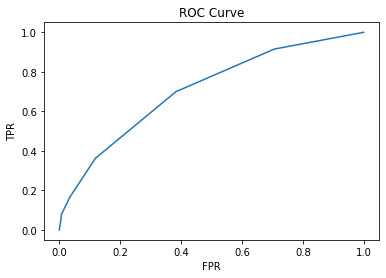

In [60]:
#Gradient Boost Tree ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol = "Top-up")
print("Area Under ROC: " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))

plt.plot(GBT['FPR'],GBT['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

Based on the curve it seems that our model is predict pretty well with AUC 0.72 and the graph look quite smooth.

##### 2.3.5 Train the model with full Top-up value = 1 

After all the previous processes, we will now train our selected model with another resampling of the training set. However, this time the Top-up value "1" will be used with 100% from the training set and the Top-up value "0" will be double similar to the 20% rebalance. Similar to the previous section the dataset will be in a portion of 1:2 from top-up value 1 to top-up value 0. Then we will fit the new resampling dataset into the selected pipeline and save the model to be used later on.

In [61]:
#New proportion of train_set
train_set = train_set.cache() #caching for faster process
train_newset2 = undersampling(train_set,1.0) #resampling value 1 to full set and doubling the value 0
re_newset = train_newset2.select(cols_train) #Select the features column to speed up process

In [62]:
#Show the result after resampling
re_newset.groupby('Top-up').count().show()

+------+-----+
|Top-up|count|
+------+-----+
|     0|50406|
|     1|25203|
+------+-----+



In [63]:
#Train new resampling dataset into the ML pipeline and save them (Save derieve from tutorial week 7)
GBT_final = pipeline_gbt.fit(re_newset)
predictions_final = GBT_final.transform(test_set)
print(compute_metrics(predictions_final,'Final_model'))
GBT_final.write().overwrite().save('best_assignment2A_model') #(zero323, 2017)

Final_model: accuracy:0.7575181758096498, precision:0.5638831513720861, recall:0.30318895763921944, and AUC:0.732874382455432


#### 3. Knowledge Sharing

#### 3.1 How many jobs are observed when training the KMeans clustering model following thecode below? Provide a screenshot from Spark UI for running a simple KMeans model training from the provided data

In [64]:
from pyspark.ml.clustering import KMeans

test_df = spark.createDataFrame([[0, 35.3, 37.5],
[1, 41.4, -23.5],
[2, 28.3, -13.3],
[3, 09.5, -9.0],
[4, 62.8, -18.23],
[5, 63.8, -18.33],
[6, 82.8, -17.23],
[7, 52.8, -13.43],
[8, 72.8, 48.23],
[9, 65.8, 15.43],
[10, 42.8, -13.23] ],
["ID","Att_1", "Att_2"])
assembler = VectorAssembler(inputCols=["Att_1", "Att_2"],outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(test_df))

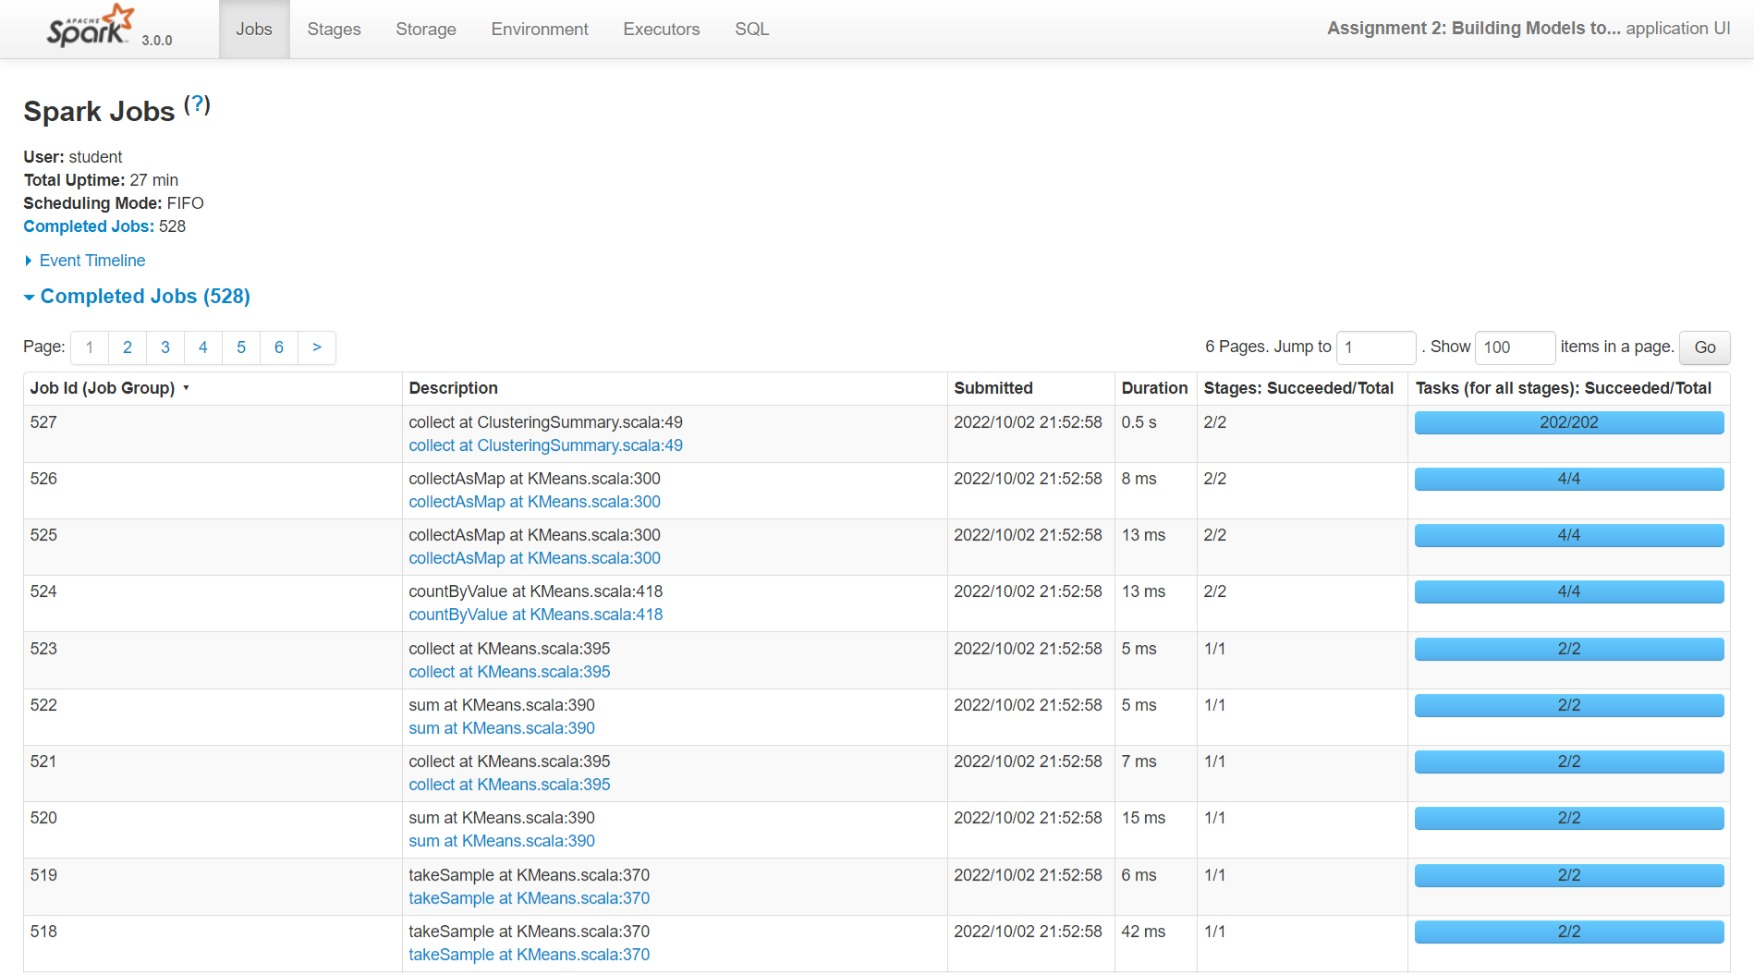

Based on the result of the Spark UI, it seems that it took around 9-10 jobs to be done for the k-means clustering starting with making a sample, sum,collect, sum and count the value before it was collect and divided into a cluster. This process is like identifying where each data points belong first and making a centroid (center point of each data point group) and calculate the distance between data points and the centroid then making a group. Then each group will be assigned new centroid based on the average range of all data points. These process will be repeat until we get all the group according to the K value we assign.

#### 3.2 What method or what kmeans method is used to choose the initial center by default in spark? What will it do if it generates a number of centers more than 'k'?

Based on the code in github, there are two default methods using in spark to choose the default initial center. the first one is choosing the center point(centroid) randomly and the other one is using K-means algorithm by Bahmani et al (Bahmani et al.,2012). This K-means algorithm is working by identify a dissimilar center of each cluster begining with assigning a random center point and then the iteration of this process will continue until it itentify where those centers have a probability proportional to their squared distance to the current cluster set. As a result, it is leading to optimal clustering performance.

However, there is a chance that it will generate a number of center more than K so this algorithm will assign a weight to each center by the number of datapoints and run a local k-means on the weighted centers to pick k of them and based on the code `bcCenters.destroy()` those center might be destroyed and restart the process to find the center again until we got to our designated number of center.

### References


- Bahmani et al. (2012). $\textit{Scalable K-Means}$. VLDB.http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf.
- JiriS (2016, Febraury 18). $\textit{Difference between na().drop() and filter(col.isNotNull) (Apache Spark)}$. https://stackoverflow.com/questions/35477472/difference-between-na-drop-and-filtercol-isnotnull-apache-spark
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Week 5:Machine Learning with Spark (Transformer, Estimator and Pipeline API)}$.https://lms.monash.edu/mod/resource/view.php?id=10523152
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Week 6:Machine Learning with Spark (Classification Using Decision Tree, Random Forest, and Logistic Regression)}$. https://lms.monash.edu/mod/resource/view.php?id=10523170
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Week 7: Machine Learning with Spark (Clustering using K-Means)}$. https://lms.monash.edu/mod/resource/view.php?id=10523193
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Week 7: Machine Learning with Spark (Model Selection and Persistance)}$. https://lms.monash.edu/mod/resource/view.php?id=10523194
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Week 8: Music Recommendation using Collaborative Filtering}$. https://lms.monash.edu/mod/resource/view.php?id=10523213
- Lin, T. (2018, June 19). $\textit{Feature Selection Using Feature Importance Score - Creating a PySpark Estimator}$. https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
- Luan, J. (2022, July 27). $\textit{A Deep Dive into Custom Spark Transformers for Machine Learning Pipelines}$. https://www.crowdstrike.com/blog/deep-dive-into-custom-spark-transformers-for-machine-learning-pipelines/
- marc. (2020, October 30). $\textit{Spark extract value to multiple columns based on name}$. https://stackoverflow.com/questions/64601083/spark-extract-value-to-multiple-columns-based-on-name
- Niko. (2015, September 1). $\textit{Create a custom Transformer in PySpark ML}$. https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
- NNK. (2022, July 10). $\textit{PySpark Retrieve DataType & Column Names of DataFrame}$. https://sparkbyexamples.com/pyspark/pyspark-find-datatype-column-names-of-dataframe/
- NNK. (2022, July 14). $\textit{Spark DataFrame Union and UnionAll}$. https://sparkbyexamples.com/spark/spark-dataframe-union-and-union-all/
- NNK. (2022, August 5). $\textit{PySpark Replace Column Values in DataFrame}$. https://sparkbyexamples.com/pyspark/pyspark-replace-column-values/
- Szabo, B. (2020, May 26).$\textit{How to Create a Seaborn Correlation Heatmap in Python?
}$. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
- thecheech (2017,October 26).  $\textit{Removing duplicate columns after a DF join in Spark}$. https://stackoverflow.com/questions/46944493/removing-duplicate-columns-after-a-df-join-in-spark
- tlanigan (2018, February 23). $\textit{How to plot a count bar chart with a Pandas DF, grouping by one categorical column and colouring by another}$. https://stackoverflow.com/questions/48939795/how-to-plot-a-count-bar-chart-with-a-pandas-df-grouping-by-one-categorical-colu
- zero323. (2017, February 17). $\textit{How to overwrite Spark ML model in PySpark?}$. https://stackoverflow.com/questions/42303705/how-to-overwrite-spark-ml-model-in-pyspark
- zhengruifeng.(nd.) $\textit{KMeans blockify input vectors}$.
https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/clustering/KMeans.scala